In [2]:
#Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip
import math
#np.random.seed(42)

In [3]:
#Function to Load images from the file
def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28 * 28)/ np.float32(256)

In [3]:
#Function to load labels from the file
def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

In [4]:
#Function to get images and labels from the corresponding files
def load_data():
    train_images = load_images('train-images-idx3-ubyte.gz')
    train_labels = load_labels('train-labels-idx1-ubyte.gz')
    test_images = load_images('t10k-images-idx3-ubyte.gz')
    test_labels = load_labels('t10k-labels-idx1-ubyte.gz')
    return train_images, train_labels, test_images, test_labels

In [5]:
#Normalize the input data to avoid exploding for sigmoid activation function
def normailize_input(train_images,test_images):
    train_mean = train_images.mean()
    test_mean = test_images.mean()
    train_std = test_images.std()
    test_std = test_images.std()
    train_images = (train_images - train_mean) / train_std
    test_images = (test_images - test_mean) / test_std
    return train_images,test_images

In [6]:
#Function to generate a numpy array for a desired output(one hot encoded)
def get_desired_output(labels):
    D = []
    for label in labels:
        output = np.zeros(10)
        output[label] = 1
        D.append(output)
    return np.array(D)

In [7]:
#Sigmoid activation function for forward propogation
def sigmoid_function(v):
    return 1/(1 + np.exp(-v))

In [8]:
#Derivative of sigmoid activation function for backward propogation
def derv_sigmoid_function(v):
    return sigmoid_function(v) * (1 - sigmoid_function(v))

In [9]:
#Function to generate weights and biases for the network, random uniform distribution
def generate_weights():
    w1 = np.random.uniform(-1,1,(100,784))
    b = np.random.uniform(-1,1,(100,1))
    w2 = np.random.uniform(-1,1,(100,100))
    c = np.random.uniform(-1,1,(100,1))
    w3 = np.random.uniform(-1,1,(10,100))
    d = np.random.uniform(-1,1,(10,1))
    W1 = np.concatenate((b,w1),axis = 1)
    W2 = np.concatenate((c,w2),axis = 1)
    W3 = np.concatenate((d,w3),axis = 1)
    return W1,W2,W3

In [10]:
train_images, train_labels, test_images, test_labels = load_data()
train_images,test_images = normailize_input(train_images,test_images)
D = get_desired_output(train_labels)
D_test = get_desired_output(test_labels)
W1,W2,W3 = generate_weights()
print('Shape of W1: {}'.format(W1.shape))
print('Shape of W2: {}'.format(W2.shape))
print('Shape of W3: {}'.format(W3.shape))

Shape of W1: (100, 785)
Shape of W2: (100, 101)
Shape of W3: (10, 101)


In [6]:
#Function to plot the enery values and misclassifications v/s the number of epochs
def plot(epochs,train_data,test_data,variant,label1,label2):
    fig,ax = plt.subplots(figsize=(8,8))
    train_misclassifications = plt.plot(epochs,train_data,label = label1)
    test_misclassifications = plt.plot(epochs,test_data,label = label2)
    if variant == 'misclassification_plot':
        plt.title('Plot of Number of Misclassifications Vs Number of epochs')
        plt.ylabel('Number of Mis classifications')
    elif variant == 'energy_plot':
        plt.title('Plot of Number of Energy Vs Number of epochs')
        plt.ylabel('Energy values')
    plt.xlabel('Number of epochs')
    ax.legend(loc = 'best')
    plt.show()
    return

In [12]:
#Function to implement forward and backward propogation and find the desired set of weights of the network
def forward_backward_prop(eta,X,X_test,D,D_test,W1,W2,W3):
    epoch = 0
    epochs = []
    errors_train = []
    errors_test = []
    energies_train = []
    energies_test = []
    classification_errors_train = []
    classification_errors_test = []
    while epoch < 200:
        #Training Data
        Y3 = []
        Y3_test = []
        energy_train = 0
        energy_test = 0
        misclassifications = 0
        misclassifications_test = 0
        for i in range(len(X)):
            #first layer
            x = X[i].reshape(784,1)
            unit = np.ones((1,1))
            v1 = np.matmul(W1,np.vstack((unit,x)))
            y1 = sigmoid_function(v1)
            #second_layer
            v2 = np.matmul(W2,np.vstack((unit,y1)))
            y2 = sigmoid_function(v2)
            #output layer
            v3 = np.matmul(W3,np.vstack((unit,y2)))
            y3 = sigmoid_function(v3)
            Y3.append(y3)
            
            #check train misclassifications
            if np.argmax(y3) != np.argmax(D[i]):
                misclassifications+= 1
            #Calculate the train energy using the function provided
            energy_train+= (np.sum(np.subtract(D[i].reshape(10,1),Y3[i])) ** 2) / 2

            #backpropogation
            delta_3 = np.multiply(np.subtract(D[i].reshape(10,1),y3),derv_sigmoid_function(v3))
            delta_2 = np.multiply(np.matmul(W3.transpose(),delta_3)[1:,:],derv_sigmoid_function(v2))
            delta_1 = np.multiply(np.matmul(W2.transpose(),delta_2)[1:,:],derv_sigmoid_function(v1))

            dE_dW1 = np.matmul(-delta_1,np.vstack((unit,x)).transpose())
            dE_dW2 = np.matmul(-delta_2,np.vstack((unit,y1)).transpose())
            dE_dW3 = np.matmul(-delta_3,np.vstack((unit,y2)).transpose())
            
            #update weights
            W1 = W1 + (eta * np.matmul(delta_1,np.vstack((unit,x)).transpose()))
            W2 = W2 + (eta * np.matmul(delta_2,np.vstack((unit,y1)).transpose()))
            W3 = W3 + (eta * np.matmul(delta_3,np.vstack((unit,y2)).transpose()))
        
        energies_train.append(energy_train)
        classification_errors_train.append(misclassifications)
        pct_mis_classifications = misclassifications/len(X)
        pct_accuracy = (len(X) - misclassifications)/len(X)
        print('epoch:',epoch)
        #print('\nTrain - Number of Misclassifications = {}'.format(misclassifications))
        #print('Train - Number of Correct Classfications = {}'.format(len(X) - misclassifications))
        print('Train - Accuracy = {}'.format(pct_accuracy * 100))
        print('Train - Percentage Misclassifications = {}'.format(pct_mis_classifications))
        
        #calculate Mean Squared train errror  
        error_train = 0
        for i in range(len(D)):
            error_train+= (np.subtract(D[i].reshape(10,1),Y3[i]) ** 2).mean()
        mse_train = error_train/len(D)
        errors_train.append(mse_train)
        
        #Test Data
        for i in range(len(X_test)):
            x = X_test[i].reshape(784,1)
            unit = np.ones((1,1))
            v1 = np.matmul(W1,np.vstack((unit,x)))
            y1 = sigmoid_function(v1)
            #second_layer
            v2 = np.matmul(W2,np.vstack((unit,y1)))
            y2 = sigmoid_function(v2)
            #output layer
            v3 = np.matmul(W3,np.vstack((unit,y2)))
            y3_test = sigmoid_function(v3)
            Y3_test.append(y3)
        
            #check test misclassifications
            if np.argmax(y3_test) != np.argmax(D_test[i]):
                misclassifications_test+= 1
            
            #Calculate the test energy using the function provided
            energy_test+= (np.sum(np.subtract(D_test[i].reshape(10,1),Y3_test[i])) ** 2) / 2
            
        energies_test.append(energy_test)
        classification_errors_test.append(misclassifications_test)
        pct_mis_classifications_test = misclassifications_test/len(X_test)
        pct_accuracy_test = (len(X_test) - misclassifications_test)/len(X_test)
        print('-' * 50)
        #print('Test - Number of Misclassifications = {}'.format(misclassifications_test))
        #print('Test - Number of Correct Classfications = {}'.format(len(X_test) - misclassifications_test))
        print('Test - Accuracy = {}'.format(pct_accuracy_test * 100))
        print('Train - Percentage Misclassifications = {}'.format(pct_mis_classifications_test))
        print('*' * 50)
        
        #calculate test error    
        error_test = 0
        for i in range(len(D_test)):
            error_test+= (np.subtract(D_test[i].reshape(10,1),Y3_test[i]) ** 2).mean()
        mse_test = error_test/len(D_test)
        errors_test.append(mse_test)
        epochs.append(epoch)
        
        #checking for iteration - End the iteration
        if epoch > 0:
            if pct_mis_classifications  <= 0.01 :
                break
            if errors_train[epoch] > errors_train[epoch-1]:
                eta = eta * 0.9
        
        epoch+= 1
    print('epoch:',epoch)
    print('\nTrain - Number of Misclassifications = {}'.format(misclassifications))
    print('Train - Number of Correct Classfications = {}'.format(len(X) - misclassifications))
    print('Train - Accuracy = {}'.format(pct_accuracy * 100))
    print('Train - Percentage Misclassifications = {}'.format(pct_mis_classifications))
    print('-' * 50)
    print('Test - Number of Misclassifications = {}'.format(misclassifications_test))
    print('Test - Number of Correct Classfications = {}'.format(len(X_test) - misclassifications_test))
    print('Test - Accuracy = {}'.format(pct_accuracy_test * 100))
    print('Train - Percentage Misclassifications = {}'.format(pct_mis_classifications_test))
    return energies_train,classification_errors_train,errors_train,energies_test,classification_errors_test,errors_test,epochs,W1,W2,W3

epoch: 0

Train - Number of Misclassifications = 20846
Train - Number of Correct Classfications = 39154
Train - Accuracy = 65.25666666666666
Train - Percentage Misclassifications = 0.3474333333333333
--------------------------------------------------
Test - Number of Misclassifications = 1721
Test - Number of Correct Classfications = 8279
Test - Accuracy = 82.78999999999999
Train - Percentage Misclassifications = 0.1721
**************************************************
epoch: 1

Train - Number of Misclassifications = 8687
Train - Number of Correct Classfications = 51313
Train - Accuracy = 85.52166666666666
Train - Percentage Misclassifications = 0.14478333333333335
--------------------------------------------------
Test - Number of Misclassifications = 1256
Test - Number of Correct Classfications = 8744
Test - Accuracy = 87.44
Train - Percentage Misclassifications = 0.1256
**************************************************
epoch: 2

Train - Number of Misclassifications = 6871
Train - 

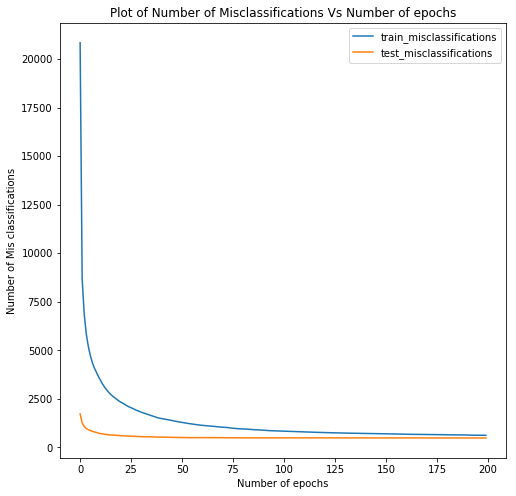

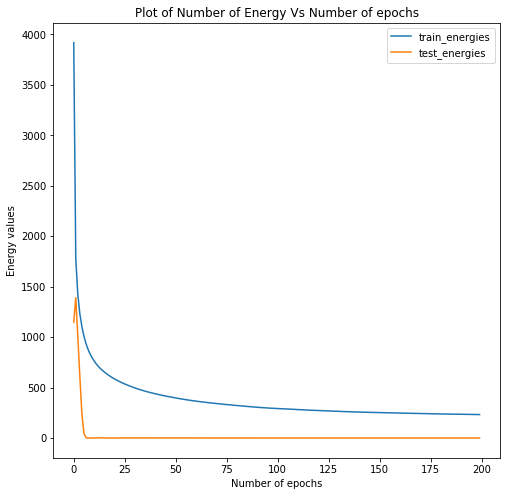

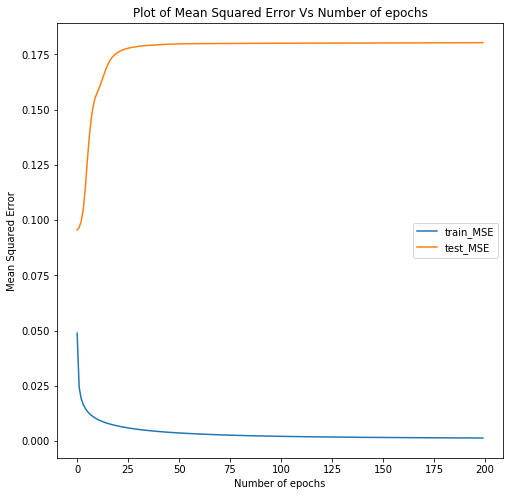

In [13]:
eta = 0.01
energies_train,classification_errors_train,mse_errors_train,energies_test,classification_errors_test,mse_errors_test,epochs,W1,W2,W3 = forward_backward_prop(eta,train_images,test_images,D,D_test,W1,W2,W3)

In [7]:
_ = plot(epochs,classification_errors_train,classification_errors_test,'misclassification_plot','train_misclassifications','test_misclassifications')
_ = plot(epochs,energies_train,energies_test,'energy_plot','train_energies','test_energies')

NameError: name 'epochs' is not defined

observations:
0. Started with all 60,000 samples of the training data, the desired output lables were one hot encoded, i.e 5 => [0,0,0,0,0,1,0,0,0,0] etc. So a final layer of 10 input neurons were considered.
1. Started with unnormalized inputs, the weight updates were not processing, after classifying a few training examples the weight updates were 0
2. Normalized input by subtracting the inputs of training data by the mean and dividing with its standard deviation - worked well as there were no 0 values.
3. Used weights that were normally distributed, the sigmoid function was exploding.
4. Used weights that were uniformly distributed between -1,1.. worked well
5. Sigmoid activation function was used for all layers, as its non linear. Tried with the tanh activation function as well, close to similar results were found. Avoided ReLU activation function as its a linear activation functions.
6. Tried with a single layer network with 100 neurons in hidden layer sigmoid activation function at 1st hidden layer and output layer, the accuracy achieved for training was atmost 75-80%. then another hidden layer was added to improve the accuracies.
7. First 200 neurons was comsidered for first hidden layer and 100 neurons for 2nd hidden layer, each epoch used to take a significant amount of time to run as there were too many weight calculation had to be performed.The accuracies with this network architecture increased compared to the network with just a single layer of hidden neurons.
8. Tried to reduce the number of neurons in the 1st hidden layer to 100, similar results were observed compared to the 200 neurons and the time taken per epoch was reduced significantly. So considered just 100 neurons at the first and second hidden layers
9. Started with a learning rate of 10, at each epoch the number of misclassification kept oscillating, indicating the gradient was oscillating and for a few epochs the accuracy decreased and then increased. The learning rate of 10 was very high.
10. The learning rate was reduced to 1, the network performed better compared to learning rate = 10,The experiment was reperated with learning rate = 0.01 and the network started performing better but it took more number of epochs to converge as the weight updates were very slow, after experimenting with different values a value of 0.1 was considered as the best parameter for learning rate.
11. First the algorithm was performed without using an regularization methods, since there was larger training examples that were available, no tricks were added, looking at the number of epochs and accuracy at each epoch, to avoid more computations, no regularization or tweaks were added to the network, the network performed well using just the basic architecture.
12. The most basic energy method i.e Euclidean measure was used to calculate the energy at each epoch of the iteration.
13. After performing the experiments many times, the number of epochs were limited to 200 or the epochs were terminated once a 99% accuracy was obtained on train data.
14. By looking at the plot of train and test misclassifications, we can see that the train and test accuraccies have performed better at each iteration.
15. Looking at the energy plots as well, we can see that the energy values decrease in the first few iterations and they remain the same after a certain number of epochs.
16. Finally the neural network architecture will be
    a. Input layer: 784 neurons
    b. First hidden layer: 100 neurons -> bias + weights (initially random uniform values between -1 and 1) -> Sigmoid activation function
    c. Second hidden layer: 100 neurons -> bias + weights (initially random uniform values between -1 and 1) -> Sigmoid activation function
    d. Output layer: 10 neurons -> Sigmoid activation function.
    e. Learning rate: 0.1
    f. threshold: 99% accuracy on training data